참고자료: https://fortes-arthur.medium.com/hands-on-speech-recognition-engine-with-keras-and-python-c60488ac53cd

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [12]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


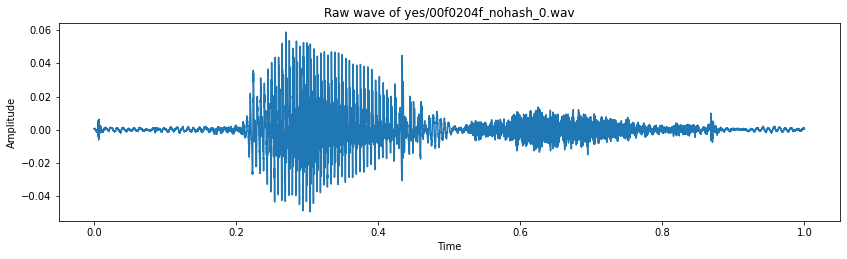

In [14]:
# 훈련 데이터 위치
train_audio_path = '/content/drive/MyDrive/인공지능/13weeks_STT/sound/audio/'

# 음성 파일 1개 시각화해보기
yes = 'yes/00f0204f_nohash_0.wav'
samples, sample_rate = librosa.load(train_audio_path + yes, sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(2, 1, 1)
ax.set_title('Raw wave of ' + yes)
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [15]:
ipd.Audio(samples, rate=sample_rate) #야쒸

In [16]:
print(sample_rate)

16000


In [17]:
# Resampling: 주파수 변경
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000) #야!

**List Comprehension**

* list와 for문만을 이용한 예시
> 1. for문 하나만 있을 때의 작성 형식 :
>> * [식  for 변수  in 리스트] 
>> * list(식 for 변수 in 리스트)
> 2. for문 여러개 있을 때의 작성 형식 :  
>> * [식 for 변수1 in 리스트1 for 변수2 in 리스트2]
>> * list(식 for 변수1 in 리스트1 for 변수2 in 리스트2)
> 3. list와 for문, if 조건문을 이용한 예시
> * for문과 if 조건문이 한개일 때 작성 형식 :
>> * [식 for 변수 in 리스트 if 조건식]
> * for문과 if 조건문이 여러개일 때 작성 형식 : 
>> * [식 for 변수1 in 리스트1 if 조건식1 ... for 변수N in 리스트N if 조건식N]
> 4. list와 for문, if .. else .. 조건문을 이용한 예시
> * for문, if .. else .. 조건문 작성 형식 : 
>> * [식1 if 조건식 else 식2 for 변수 in 리스트 ]

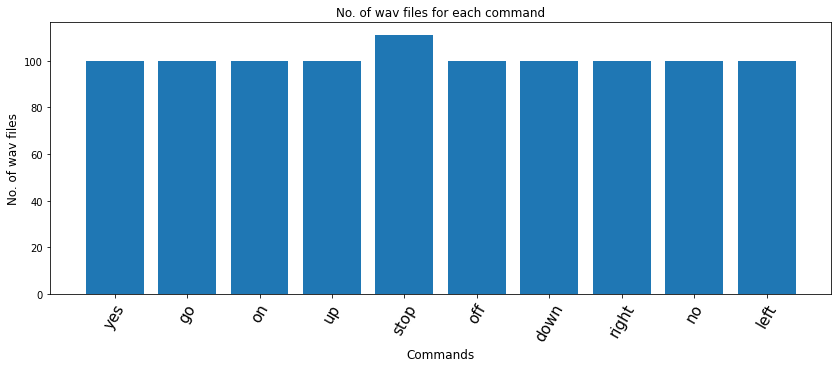

In [18]:
# 오디오 데이터 가져오기
labels = os.listdir(train_audio_path)
no_of_waves = []
waves = []
for label in labels:
  waves = [f for f in os.listdir(train_audio_path + label) if f.endswith('.wav')]
  no_of_waves.append(len(waves))

plt.figure(figsize=(14, 5))
index = np.arange(len(labels))
plt.bar(index, no_of_waves)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No. of wav files', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of wav files for each command')
plt.show()

In [19]:
labels

['yes', 'go', 'on', 'up', 'stop', 'off', 'down', 'right', 'no', 'left']

In [26]:
# 오디오 파일 전처리
# 1. Resampling: 주파수 변환
# 2. 1초보다 짧은 음성 파일 삭제
from tqdm import tqdm

all_wave = []
all_label = []

for label in labels:
  waves = [f for f in os.listdir(train_audio_path + label) if f.endswith('.wav')]
  for wav in tqdm(waves):
    samples, sample_rate = librosa.load(train_audio_path + label + '/' + wav, sr=16000)
    samples = librosa.resample(samples, sample_rate, 8000)
    if(len(samples) == 8000):
      all_wave.append(samples)
      all_label.append(label)

100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


In [27]:
print(len(all_label), len(all_wave))

910 910


In [29]:
# label 문자열을 one-hot encoding으로 변환하여 y값 생성하기

from sklearn.preprocessing import LabelEncoder
import pandas as pd

le = LabelEncoder()
tmp = le.fit_transform(all_label)
y = pd.get_dummies(tmp).values

y.shape

(910, 10)

In [30]:
# 오디오 데이터를 2차원 배열에서 3차원 배열로 변환
all_wave=np.array(all_wave).reshape(-1, 8000, 1)
all_wave.shape

(910, 8000, 1)

In [34]:
# 훈련 데이터와 시험 데이터로 나누기
from sklearn.model_selection import train_test_split

# stratify: 지정한 Data의 비율을 유지한다. 
#           예를 들어, Label Set인 Y가 25%의 0과 75%의 1로 이루어진 Binary Set일 때, 
#           stratify=Y로 설정하면 나누어진 데이터셋들도 0과 1을 각각 25%, 75%로 유지한 채 분할된다.

x_train, x_val, y_train, y_val = train_test_split(all_wave, y, test_size = 0.2, random_state=7, shuffle=True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((728, 8000, 1), (182, 8000, 1), (728, 10), (182, 10))

In [35]:
# 모델 구성하기
from keras.layers import Bidirectional, BatchNormalization, CuDNNGRU, TimeDistributed
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

**Functional API로 만든 모델**

Functional API는 각 층을 일종의 함수(function)로서 정의합니다. 그리고 각 함수를 조합하기 위한 연산자들을 제공하는데, 이를 이용하여 신경망을 설계합니다. Functional API로 FFNN, RNN 등 다양한 모델을 만들면서 기존의 sequential API와의 차이를 이해해봅시다.

Functional API는 입력의 크기(shape)를 명시한 입력층(Input layer)을 모델의 앞단에 정의해주어야 합니다.

* Input() 함수에 입력의 크기를 정의합니다.
* 이전층을 다음층 함수의 입력으로 사용하고, 변수에 할당합니다.
* Model() 함수에 입력과 출력을 정의합니다.


**모델 설계**

* Conv1d 및 GRU 계층을 사용하여 음성 인식에 사용되는 네트워크를 모델링
* Conv1d는 한 차원만을 따라 컨볼루션을 수행하는 컨볼루션 신경망
* GRU(Gated Recurrent Unit)는 표준 순환 신경망과 함께 제공되는 기울기 소실 문제를 해결하는 것을 목표함. GRU도 LSTM의 변형으로 볼 수 있음


In [44]:
K.clear_session()

inputs = Input(shape=(8000, 1))
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(inputs)

#First Conv1D layer
x = Conv1D(8, 13, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Second Conv1D layer
x = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Third Conv1D layer
x = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#GRU(Gated Recurrent Unit) layer
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

x = Bidirectional(CuDNNGRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=False), merge_mode='sum')(x)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

#Dense Layer 1
x = Dense(256, activation='relu')(x)
outputs = Dense(len(labels), activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 batch_normalization (BatchN  (None, 8000, 1)          4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424  

In [45]:
# 학습하기

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10,
                           min_delta = 0.001)
hist = model.fit(x_train, y_train, epochs=100, callbacks=[early_stop], 
                 batch_size=32, validation_data=(x_val, y_val))

Epoch 1/100
23/23 [==============================] - 27s 557ms/step - loss: 2.4729 - accuracy: 0.1044 - val_loss: 2.3040 - val_accuracy: 0.0879
Epoch 2/100
23/23 [==============================] - 10s 449ms/step - loss: 2.3584 - accuracy: 0.1058 - val_loss: 2.3189 - val_accuracy: 0.0934
Epoch 3/100
23/23 [==============================] - 10s 450ms/step - loss: 2.3477 - accuracy: 0.1236 - val_loss: 2.3521 - val_accuracy: 0.0440
Epoch 4/100
23/23 [==============================] - 10s 446ms/step - loss: 2.3422 - accuracy: 0.1195 - val_loss: 2.3531 - val_accuracy: 0.0769
Epoch 5/100
23/23 [==============================] - 10s 442ms/step - loss: 2.2369 - accuracy: 0.1799 - val_loss: 2.4393 - val_accuracy: 0.0934
Epoch 6/100
23/23 [==============================] - 10s 443ms/step - loss: 1.8849 - accuracy: 0.2857 - val_loss: 2.8707 - val_accuracy: 0.1209
Epoch 7/100
23/23 [==============================] - 10s 444ms/step - loss: 1.6550 - accuracy: 0.3599 - val_loss: 2.6633 - val_accuracy:

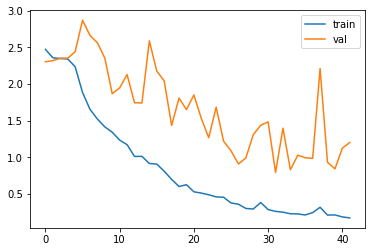

In [46]:
# 훈련 결과 그래프로 확인하기

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.show()

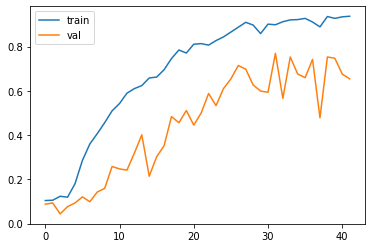

In [47]:
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [49]:
# 결과를 문자로 보여주기 위한 함수 정의
classes = list(le.classes_)
print(classes)

def predict(audio):
  prob = model.predict(audio.reshape(1, 8000, 1))
  index = np.argmax(prob[0])
  return classes[index]

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


In [50]:
# 새로운 데이터로 확인하기

test_audio_path = '/content/drive/MyDrive/인공지능/13weeks_STT/sound/test/'

for f in os.listdir(test_audio_path):
  samples, sample_rate = librosa.load(test_audio_path + f, sr = 16000)
  samples = librosa.resample(samples, sample_rate, 8000)
  print('음성파일: {}에 대해서 {}라고 예측하였습니다.'.format(f, predict(samples)))



음성파일: yes.wav에 대해서 yes라고 예측하였습니다.
음성파일: stop.wav에 대해서 stop라고 예측하였습니다.
음성파일: right.wav에 대해서 right라고 예측하였습니다.
음성파일: left.wav에 대해서 yes라고 예측하였습니다.
음성파일: up.wav에 대해서 up라고 예측하였습니다.
음성파일: go.wav에 대해서 no라고 예측하였습니다.
음성파일: on.wav에 대해서 on라고 예측하였습니다.
음성파일: down.wav에 대해서 down라고 예측하였습니다.
음성파일: off.wav에 대해서 on라고 예측하였습니다.
